In [64]:
from pathlib import Path
import time
import torch
import numpy as np
from dataset import WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_sim import Config, TSTransformer
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

In [65]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [66]:
# Parameters

# Overall settings
in_model = 'models/ckpt_430_fine-tuned_3100000_lower_noise.pt'
seed = 42
# System settings
noise = 0.01
# Compute settings
cuda_device = 'cuda:0'
threads = 10
# Test settings
batched_iters = 10
batch_n_per_iter = 32
ctx_len = 16000
slide = 400
n_query = 5

In [67]:
# Configure compute
torch.manual_seed(seed)
if threads > 0:
    torch.set_num_threads(threads)
use_cuda = torch.cuda.is_available()
device_name = cuda_device if use_cuda else "cpu"
print(device_name)
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu'
torch.set_float32_matmul_precision("high")

cuda:0


In [68]:
exp_data = torch.load(in_model, map_location=device, weights_only=False)
cfg_model = exp_data["cfg"]

model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"])

<All keys matched successfully>

In [69]:
ctx_divisions = int((ctx_len - cfg_model.seq_len_ctx) / slide) + 1
batch_size = batched_iters * batch_n_per_iter
lin_opts = dict(mag_range=cfg_model.mag_range, phase_range=cfg_model.phase_range, strictly_proper=True)
test_ds = WHDataset(nx=cfg_model.nx, nu=cfg_model.nu, ny=cfg_model.ny,
                    seq_len=ctx_len +
                            cfg_model.seq_len_skip +
                            cfg_model.seq_len_n_in +
                            cfg_model.seq_len_new * n_query,
                    system_seed=seed, input_seed=seed+1, noise_seed=seed+2, **lin_opts)

test_dl = DataLoader(test_ds, batch_size=batch_n_per_iter, num_workers=threads)

In [70]:
all_rmse = []
all_y_means = []
all_y_trues = []
all_var_inv = []

start = time.time()

for batch_itr, (batch_y, batch_u) in enumerate(test_dl):
    if batch_itr >= batched_iters:
        break
    print(f'Batch iter {batch_itr+1}')

    batch_y = batch_y.to(device)
    batch_u = batch_u.to(device)
    noise_std = 0.0
    with torch.no_grad():
        batch_y_ctx = batch_y[:, :ctx_len, :]
        batch_u_ctx = batch_u[:, :ctx_len, :]
        batch_y_new = batch_y[:, ctx_len + cfg_model.seq_len_skip:, :]
        batch_u_new = batch_u[:, ctx_len + cfg_model.seq_len_skip:, :]
        batch_y_ctx = batch_y_ctx + torch.randn(batch_y_ctx.shape).to(device) * noise_std

        means_rmse = [[[] for _ in range(ctx_divisions)] for _ in range(batch_u.shape[0])]
        batch_y_means = [[[] for _ in range(ctx_divisions)] for _ in range(batch_u.shape[0])]
        batch_y_trues = [[[] for _ in range(ctx_divisions)] for _ in range(batch_u.shape[0])]
        variance_invs = [[[] for _ in range(ctx_divisions)] for _ in range(batch_u.shape[0])]
        for cd in range(ctx_divisions):
            batch_y_ctx_dv = batch_y_ctx[:, cd * slide:cd * slide + cfg_model.seq_len_ctx, :]
            batch_u_ctx_dv = batch_u_ctx[:, cd * slide:cd * slide + cfg_model.seq_len_ctx, :]

            batch_y_mean = None
            for rq in range(n_query):

                batch_u_new_query = batch_u_new[:, rq * cfg_model.seq_len_new:rq * cfg_model.seq_len_new + cfg_model.seq_len_n_in + cfg_model.seq_len_new, :]

                # clone to avoid propagation of the repeat_query changes on the tensor
                batch_y_new_query = batch_y_new[:, rq * cfg_model.seq_len_new:rq * cfg_model.seq_len_new + cfg_model.seq_len_n_in + cfg_model.seq_len_new, :].clone()

                if batch_y_mean is not None:
                    batch_y_new_query[:, :cfg_model.seq_len_n_in, :] = batch_y_mean[:, cfg_model.seq_len_new - cfg_model.seq_len_n_in:, :]

                for i in range(batch_y_ctx_dv.shape[2]):
                    batch_y_mean, batch_y_std, _, rmse = model(batch_y_ctx_dv[:, :, i:i+1], batch_u_ctx_dv, batch_u_new_query, batch_y_new_query[:, :, i:i+1], cfg_model.seq_len_n_in)

                variance_inv = (1 / batch_y_std**2).to("cpu").detach().numpy()
                batch_y_model = batch_y_mean.to("cpu").detach().numpy()
                batch_y_new_query = batch_y_new_query.to("cpu").detach().numpy()

                for i in range(batch_n_per_iter):
                    batch_rmse = np.sqrt(mean_squared_error(batch_y_new_query[i, cfg_model.seq_len_n_in:, 0],
                                                            batch_y_model[i, :, 0]))
                    means_rmse[i][cd].append(batch_rmse)
                    batch_y_means[i][cd].append(batch_y_model[i])
                    batch_y_trues[i][cd].append(batch_y_new_query[i])
                    variance_invs[i][cd].append(variance_inv[i])

        all_rmse.extend(means_rmse)
        all_y_means.extend(batch_y_means)
        all_y_trues.extend(batch_y_trues)
        all_var_inv.extend(variance_invs)

print('test time: ' + str(time.time() - start) + 's')

all_rmse = np.array(all_rmse)
all_y_means = np.array(all_y_means)
mean_div_all_y = np.mean(all_y_means, axis=1)
all_y_trues = np.array(all_y_trues)[:, 0]
all_var_inv = np.array(all_var_inv)

Batch iter 1
Batch iter 2
Batch iter 3
Batch iter 4
Batch iter 5
Batch iter 6
Batch iter 7
Batch iter 8
Batch iter 9
Batch iter 10
test time: 419.89586186408997s


In [71]:
plot_batch = 0
save_fig = False

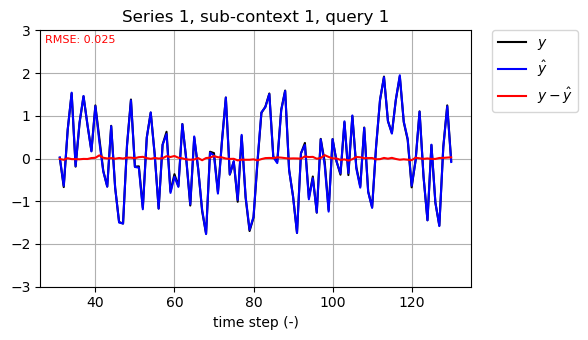

<Figure size 640x480 with 0 Axes>

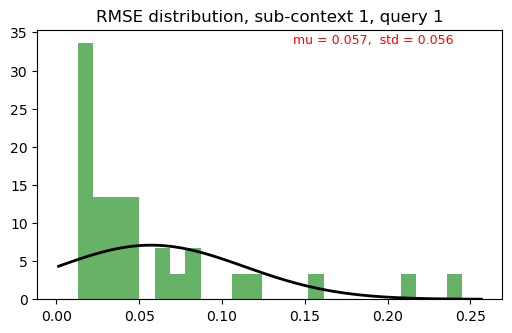

<Figure size 640x480 with 0 Axes>

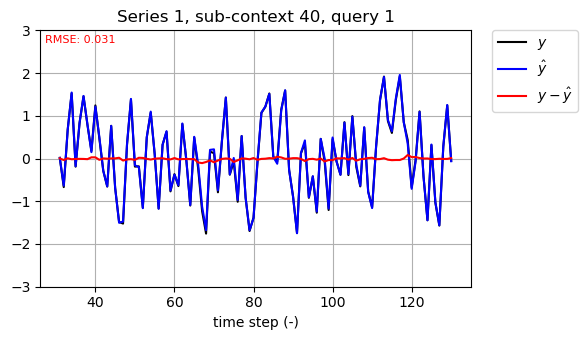

<Figure size 640x480 with 0 Axes>

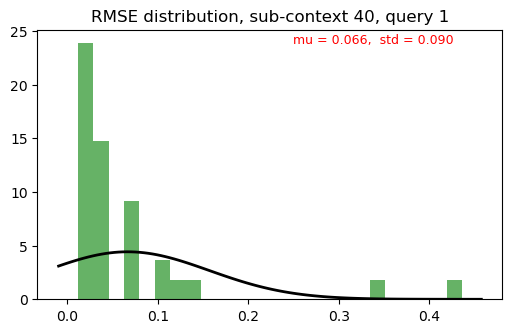

<Figure size 640x480 with 0 Axes>

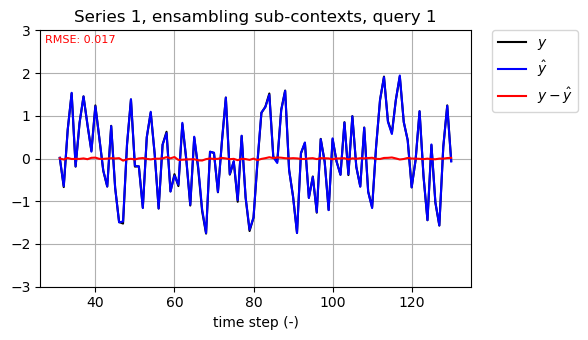

<Figure size 640x480 with 0 Axes>

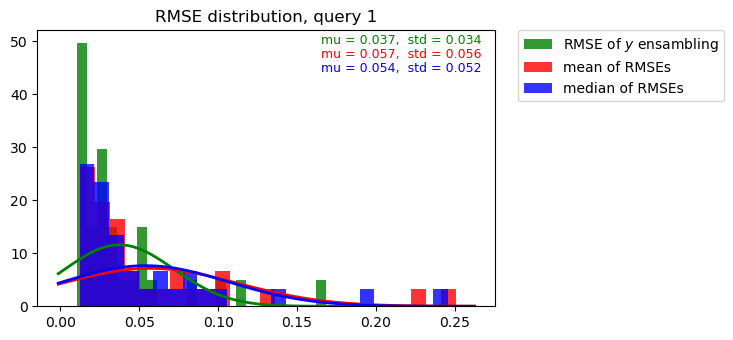

<Figure size 640x480 with 0 Axes>

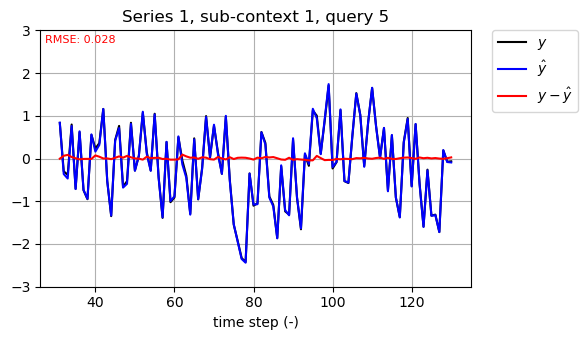

<Figure size 640x480 with 0 Axes>

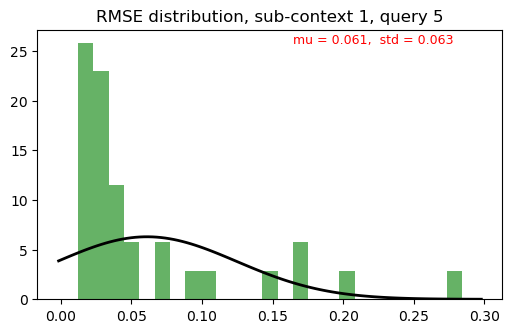

<Figure size 640x480 with 0 Axes>

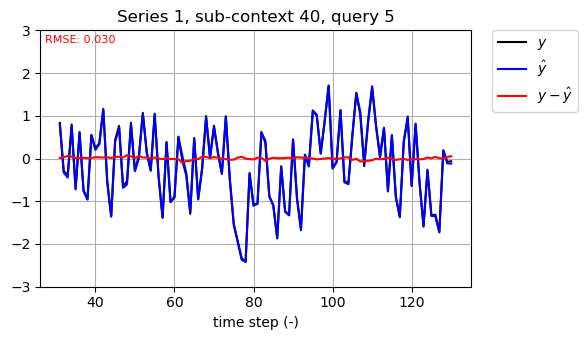

<Figure size 640x480 with 0 Axes>

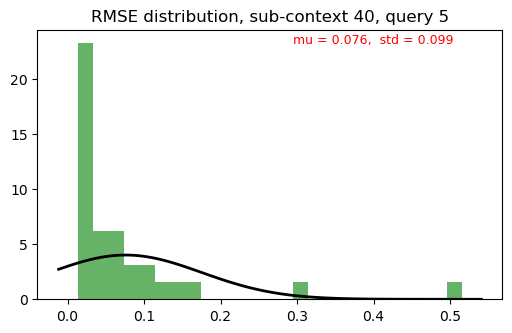

<Figure size 640x480 with 0 Axes>

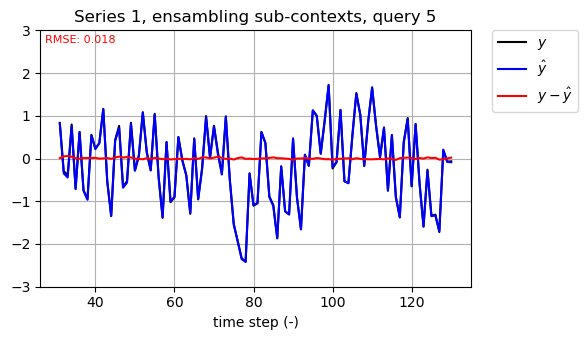

<Figure size 640x480 with 0 Axes>

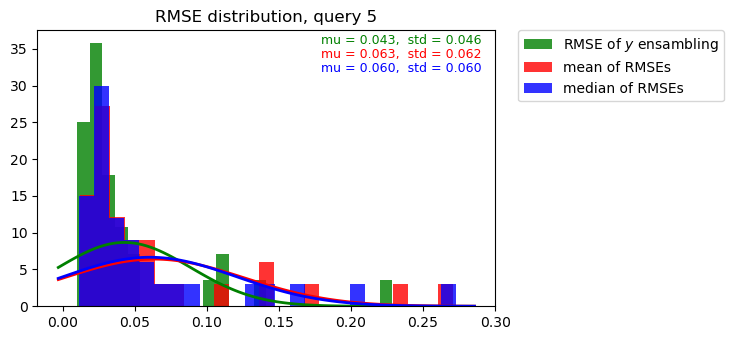

<Figure size 640x480 with 0 Axes>

In [72]:
queries_rmses = []
queries_trues = []
queries_model_ctx = []
queries_model_ensambling = []
queries_variance_inv = []
for rq in range(n_query):
    for cd in range(ctx_divisions):
        if (cd == 0 or cd == ctx_divisions - 1) and (rq == 0 or rq == n_query - 1):
            batch_sim_err = all_y_trues[:, rq, cfg_model.seq_len_n_in:, :] - all_y_means[:, cd, rq, :, :]

            plt.figure(figsize=(6, 3.5))
            plt.ylim(-3, 3)
            t = np.arange(1, cfg_model.seq_len_new + 1) + cfg_model.seq_len_n_in
            plt.plot(t, all_y_trues[plot_batch, rq, cfg_model.seq_len_n_in:, :], 'k', label=r"$y$")
            plt.plot(t, all_y_means[plot_batch, cd, rq, :, :], 'b', label=r"$\hat y$")
            plt.plot(t, batch_sim_err[plot_batch, :, :], 'r', label=r"$y - \hat y$")
            plt.grid(True)
            plt.title(f"Series {plot_batch+1}, sub-context {cd+1}, query {rq+1}")
            plt.xlabel("time step (-)")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.text(0.01, 0.95, f'RMSE: {all_rmse[plot_batch, cd, rq]:.3f}', size=8, color='red', transform=plt.gca().transAxes)
            plt.tight_layout()
            plt.show()
            plt.cla()
            plt.clf()

            plt.figure(figsize=(6, 3.5))
            mu, std = norm.fit(all_rmse[:, cd, rq])
            plt.hist(all_rmse[:, cd, rq], bins=25, density=True, alpha=0.6, color='g')
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            plt.plot(x, p, 'k', linewidth=2)
            plt.title(f"RMSE distribution, sub-context {cd+1}, query {rq+1}")
            plt.text(0.55, 0.95, "mu = %.3f,  std = %.3f" % (mu, std), size=9, color='red',
                     transform=plt.gca().transAxes)
            plt.show()
            plt.cla()
            plt.clf()

    batch_sim_err_mean = all_y_trues[:, rq, cfg_model.seq_len_n_in:, :] - mean_div_all_y[:, rq, :, :]

    rmse_mean = np.sqrt(mean_squared_error(all_y_trues[plot_batch, rq, cfg_model.seq_len_n_in:, 0],
                                           mean_div_all_y[plot_batch, rq, :, 0]))

    mean_all_rmse = []
    for b in range(len(mean_div_all_y)):
        batch_rmse_mean = np.sqrt(mean_squared_error(all_y_trues[b, rq, cfg_model.seq_len_n_in:, 0],
                                                     mean_div_all_y[b, rq, :, 0]))
        mean_all_rmse.append(batch_rmse_mean)

    queries_rmses.append(mean_all_rmse)
    queries_trues.append(all_y_trues[:, rq, cfg_model.seq_len_n_in:, 0])
    queries_model_ctx.append(all_y_means[:, :, rq, :, 0])
    queries_model_ensambling.append(mean_div_all_y[:, rq, :, 0])
    queries_variance_inv.append(all_var_inv[:, :, rq, :, 0])

    rmse_no_ensambling = np.mean(all_rmse[:, :, rq], axis=1)
    median_rmse = np.median(all_rmse[:, :, rq], axis=1)

    if rq == 0 or rq == n_query - 1:
        plt.figure(figsize=(6, 3.5))
        plt.ylim(-3, 3)
        t = np.arange(1, cfg_model.seq_len_new + 1) + cfg_model.seq_len_n_in
        plt.plot(t, all_y_trues[plot_batch, rq, cfg_model.seq_len_n_in:, :], 'k', label="$y$")
        plt.plot(t, mean_div_all_y[plot_batch, rq, :, :], 'b', label=r"$\hat y$")
        plt.plot(t, batch_sim_err_mean[plot_batch, :, :], 'r', label=r"$y - \hat y$")
        plt.grid(True)
        plt.title(f"Series {plot_batch+1}, ensambling sub-contexts, query {rq+1}")
        plt.xlabel("time step (-)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.text(0.01, 0.95, f'RMSE: {rmse_mean:.3f}', size=8, color='red',
                 transform=plt.gca().transAxes)
        plt.tight_layout()
        plt.show()
        plt.cla()
        plt.clf()

        plt.figure(figsize=(7.5, 3.5))
        mu, std = norm.fit(mean_all_rmse)
        mu2, std2 = norm.fit(rmse_no_ensambling)
        mu3, std3 = norm.fit(median_rmse)
        plt.hist(mean_all_rmse, bins=25, density=True, alpha=0.8, color='g', label=r"RMSE of $y$ ensambling")
        plt.hist(rmse_no_ensambling, bins=25, density=True, alpha=0.8, color='r', label="mean of RMSEs")
        plt.hist(median_rmse, bins=25, density=True, alpha=0.8, color='b', label="median of RMSEs")
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'g', linewidth=2)
        p = norm.pdf(x, mu2, std2)
        plt.plot(x, p, 'r', linewidth=2)
        p = norm.pdf(x, mu3, std3)
        plt.plot(x, p, 'b', linewidth=2)
        plt.title(f"RMSE distribution, query {rq+1}")
        plt.text(0.62, 0.95, "mu = %.3f,  std = %.3f" % (mu, std), size=9, color='green',
                 transform=plt.gca().transAxes)
        plt.text(0.62, 0.9, "mu = %.3f,  std = %.3f" % (mu2, std2), size=9, color='red',
                 transform=plt.gca().transAxes)
        plt.text(0.62, 0.85, "mu = %.3f,  std = %.3f" % (mu3, std3), size=9, color='blue',
                 transform=plt.gca().transAxes)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        plt.show()
        plt.cla()
        plt.clf()

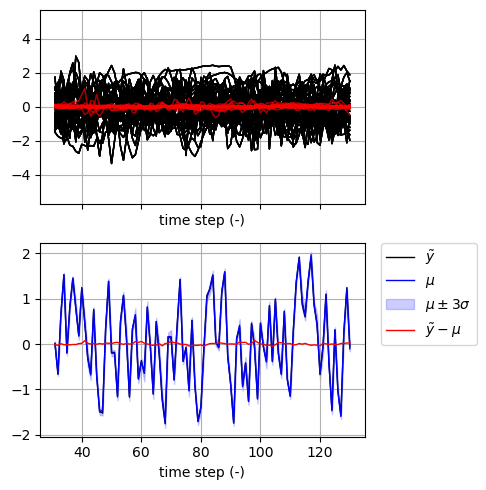

<Figure size 640x480 with 0 Axes>

In [73]:
cd = 1
rq = 0
std_plot = np.sqrt(1 / all_var_inv[plot_batch, cd, rq, :, :])
y_plus = all_y_means[plot_batch, cd, rq, :, :] + std_plot * 3
y_minus = all_y_means[plot_batch, cd, rq, :, :] - std_plot * 3
batch_sim_err = all_y_trues[:, rq, cfg_model.seq_len_n_in:, :] - all_y_means[:, 0, rq, :, :]

fix, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5, 5))
ax[0].plot(t, all_y_trues[:, rq, cfg_model.seq_len_n_in:, :].squeeze(-1).T, "k", alpha=0.5, linewidth=1)
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label=r"$y$")
ax[0].plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.1, linewidth=1)
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label=r"$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)
ax[1].plot(t, all_y_trues[plot_batch, rq, cfg_model.seq_len_n_in:, :], 'k', label=r"$\tilde y$", linewidth=1)
ax[1].plot(t, all_y_means[plot_batch, cd, rq, :, :], 'b', label=r"$\mu$", linewidth=1)
ax[1].fill_between(t, y_minus[:, 0], y_plus[:, 0], label=r"$\mu \pm 3\sigma$", color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[plot_batch, :, :], 'r', label=r"$\tilde y - \mu$", linewidth=1)
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
if save_fig:
    plt.savefig(f'fig/paper_patch_all_batch.pdf')
plt.show()
plt.cla()
plt.clf()

In [74]:
queries_rmses = np.stack(queries_rmses, axis=1)
queries_trues = np.stack(queries_trues, axis=1).reshape(-1, n_query*cfg_model.seq_len_new)
queries_model_ctx = np.stack(queries_model_ctx, axis=2).reshape(-1, ctx_divisions, n_query*cfg_model.seq_len_new)
queries_model_ensambling = np.stack(queries_model_ensambling, axis=1).reshape(-1, n_query*cfg_model.seq_len_new)
queries_variance_inv = np.stack(queries_variance_inv, axis=2).reshape(-1, ctx_divisions, n_query*cfg_model.seq_len_new)

queries_weighted_ensambling = np.sum(queries_model_ctx * queries_variance_inv, axis=1)

sum_var_inv = np.sum(queries_variance_inv, axis=1)

rmse_means_all_queries = []
mean_rmse_no_ensambling = []
median_rmse_no_ensambling = []
rmse_weighted_ensambling = []
for b in range(batch_size):
    rmse_mean_all_queries = np.sqrt(mean_squared_error(queries_trues[b], queries_model_ensambling[b]))
    rmse_means_all_queries.append(rmse_mean_all_queries)
    rmse_ctxs_queries = []
    for ctx in range(ctx_divisions):
        rmse_ctxs_queries.append(np.sqrt(mean_squared_error(queries_trues[b], queries_model_ctx[b, ctx])))
    mean_rmse_no_ensambling.append(np.mean(rmse_ctxs_queries))
    median_rmse_no_ensambling.append(np.median(rmse_ctxs_queries))

    rmse_weighted_ensambling.append(np.sqrt(mean_squared_error(queries_trues[b], queries_weighted_ensambling[b] / sum_var_inv[b])))


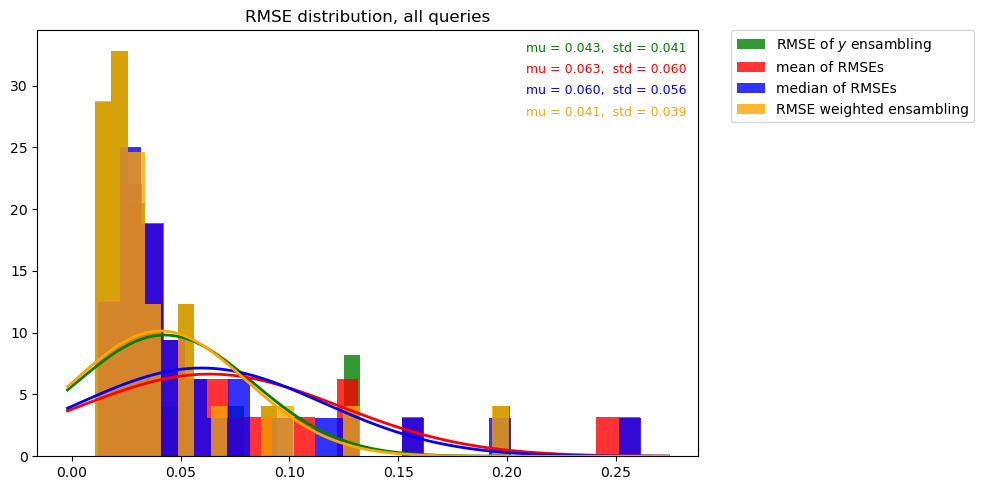

<Figure size 640x480 with 0 Axes>

In [75]:
plt.figure(figsize=(10, 5))
mu, std = norm.fit(rmse_means_all_queries)
mu2, std2 = norm.fit(mean_rmse_no_ensambling)
mu3, std3 = norm.fit(median_rmse_no_ensambling)
mu4, std4 = norm.fit(rmse_weighted_ensambling)
plt.hist(rmse_means_all_queries, bins=25, density=True, alpha=0.8, color='g', label="RMSE of $y$ ensambling")
plt.hist(mean_rmse_no_ensambling, bins=25, density=True, alpha=0.8, color='r', label="mean of RMSEs")
plt.hist(median_rmse_no_ensambling, bins=25, density=True, alpha=0.8, color='b', label="median of RMSEs")
plt.hist(rmse_weighted_ensambling, bins=25, density=True, alpha=0.8, color='orange', label="RMSE weighted ensambling")

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)
p = norm.pdf(x, mu2, std2)
plt.plot(x, p, 'r', linewidth=2)
p = norm.pdf(x, mu3, std3)
plt.plot(x, p, 'b', linewidth=2)
p = norm.pdf(x, mu4, std4)
plt.plot(x, p, 'orange', linewidth=2)
plt.title(f"RMSE distribution, all queries")
plt.text(0.74, 0.95, "mu = %.3f,  std = %.3f" % (mu, std), size=9, color='green',
         transform=plt.gca().transAxes)
plt.text(0.74, 0.9, "mu = %.3f,  std = %.3f" % (mu2, std2), size=9, color='red',
         transform=plt.gca().transAxes)
plt.text(0.74, 0.85, "mu = %.3f,  std = %.3f" % (mu3, std3), size=9, color='blue',
         transform=plt.gca().transAxes)
plt.text(0.74, 0.8, "mu = %.3f,  std = %.3f" % (mu4, std4), size=9, color='orange',
         transform=plt.gca().transAxes)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
if save_fig:
    plt.savefig(f'fig/RMSE_ctx{cfg_model.seq_len_ctx}_seed{seed}_all_queries_div_mean')
plt.show()
plt.cla()
plt.clf()